In [63]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [64]:
x_range = (0.0, 10)  # Domain for the ODE
initial_conditions = [
    {'type': 'y', 'value': 1.0, 'x': 0.0},    # y(0) = 1
    {'type': 'y\'', 'value': 0.0, 'x': 0.0},  # y'(0) = 0
]

learning_rate = 0.001
num_epochs = 10000

In [65]:
class Network(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Network, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, H)
        self.linear4 = torch.nn.Linear(H, D_out)
        
        # Initialize biases and weights
        torch.nn.init.constant_(self.linear1.bias, 0.)
        torch.nn.init.constant_(self.linear2.bias, 0.)
        torch.nn.init.constant_(self.linear3.bias, 0.)
        torch.nn.init.constant_(self.linear4.bias, 0.)
        
        torch.nn.init.normal_(self.linear1.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear2.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear3.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear4.weight, mean=0, std=0.1)

    def forward(self, x):
        y1 = torch.tanh(self.linear1(x))
        y2 = torch.tanh(self.linear2(y1))
        y3 = torch.tanh(self.linear3(y2))
        y = self.linear4(y3)
        return y

In [66]:
D_in, H, D_out = 1, 200, 1  # Example dimensions, can be modified based on ODE requirements
model_real = Network(D_in, H, D_out)
model_imag = Network(D_in, H, D_out)
optimizer = optim.Adam(
    list(model_real.parameters()) + list(model_imag.parameters()), 
    lr=learning_rate, weight_decay=1e-5
)

In [67]:
def energy_functional(x, y_real, dy_dx_real, y_imag, dy_dx_imag):
    """
    Example: 0.5 * (dy_dx**2) + 0.5 * (y**2), split into real and imaginary components.
    """
    # Compute second derivatives
    d2y_dx2_real = torch.autograd.grad(dy_dx_real, x, torch.ones_like(dy_dx_real), create_graph=True)[0]
    d2y_dx2_imag = torch.autograd.grad(dy_dx_imag, x, torch.ones_like(dy_dx_imag), create_graph=True)[0]

    # Define the real and imaginary parts of the ODE residual
    # residual_real = 0.5 * (d2y_dx2_real ** 2) - 0.5 * (y_real ** 2)
    # residual_imag = 0.5 * (d2y_dx2_imag ** 2)- 0.5 * (y_imag ** 2)
    residual_real = d2y_dx2_real + y_real
    residual_imag = d2y_dx2_imag + y_imag

    energy = residual_real**2 + residual_imag**2
    return energy

In [68]:
def compute_energy_integral(model_real, model_imag, x_range, num_points=1000):
    """Compute the integral of the energy functional over the specified x range."""
    x_min, x_max = x_range
    x = torch.linspace(x_min, x_max, num_points).view(-1, 1)
    x.requires_grad = True

    y_real = model_real(x)
    y_imag = model_imag(x)
    dy_dx_real = torch.autograd.grad(y_real, x, torch.ones_like(y_real), create_graph=True)[0]
    dy_dx_imag = torch.autograd.grad(y_imag, x, torch.ones_like(y_imag), create_graph=True)[0]

    energy_vals = energy_functional(x, y_real, dy_dx_real, y_imag, dy_dx_imag)
    integral = torch.mean(energy_vals) * (x_max - x_min)
    return integral

In [69]:
def apply_initial_conditions(model_real, model_imag, initial_conditions):
    ivp_residuals = []
    for ivp in initial_conditions:
        x_ivp = torch.tensor([[ivp['x']]], requires_grad=True)
        y_real = model_real(x_ivp)
        y_imag = model_imag(x_ivp)

        if ivp['type'] == 'y':
            ivp_residual = y_real - ivp['value']  # Only applies to the real part
        elif ivp['type'] == 'y\'':
            dy_dx_real = torch.autograd.grad(y_real, x_ivp, torch.ones_like(x_ivp), create_graph=True)[0]
            ivp_residual = dy_dx_real - ivp['value']  # Only applies to the real part

        ivp_residuals.append(ivp_residual**2)

    return torch.sum(torch.stack(ivp_residuals))

In [70]:
def train(model_real, model_imag, optimizer, x_range, initial_conditions, num_epochs):
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        energy_integral = compute_energy_integral(model_real, model_imag, x_range)

        ivp_residual = apply_initial_conditions(model_real, model_imag, initial_conditions)

        loss = energy_integral + 500 * ivp_residual
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

In [71]:
train(model_real, model_imag, optimizer, x_range, initial_conditions, num_epochs)


Epoch 0, Loss: 650.46435546875
Epoch 100, Loss: 1.630407452583313
Epoch 200, Loss: 0.8539147973060608
Epoch 300, Loss: 0.6087659001350403
Epoch 400, Loss: 0.5403299927711487
Epoch 500, Loss: 0.5109018087387085
Epoch 600, Loss: 0.49171751737594604
Epoch 700, Loss: 0.47545352578163147
Epoch 800, Loss: 0.4723948538303375
Epoch 900, Loss: 0.4479319751262665
Epoch 1000, Loss: 0.898491382598877
Epoch 1100, Loss: 0.4248048961162567
Epoch 1200, Loss: 1.2521135807037354
Epoch 1300, Loss: 0.40490829944610596
Epoch 1400, Loss: 0.39253944158554077
Epoch 1500, Loss: 0.4080444574356079
Epoch 1600, Loss: 0.3742034435272217
Epoch 1700, Loss: 0.3614466190338135
Epoch 1800, Loss: 0.3824913203716278
Epoch 1900, Loss: 0.346273273229599
Epoch 2000, Loss: 0.33104151487350464
Epoch 2100, Loss: 0.31753233075141907
Epoch 2200, Loss: 0.3041374087333679
Epoch 2300, Loss: 0.3211490511894226
Epoch 2400, Loss: 0.2829256057739258
Epoch 2500, Loss: 0.26890379190444946
Epoch 2600, Loss: 0.2554260194301605
Epoch 2700, 

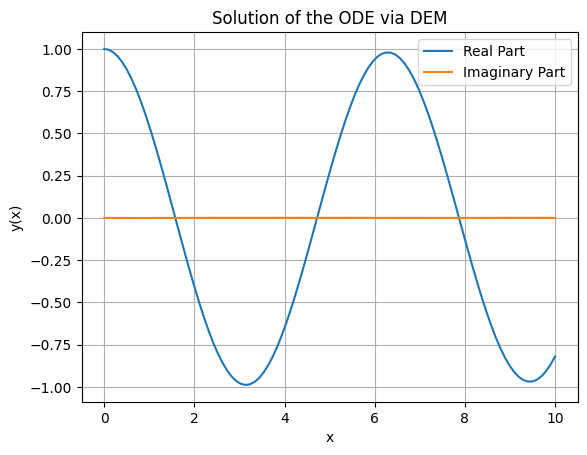

In [72]:
def visualize_solution(model_real, model_imag, x_range):
    """Visualize the solution learned by the neural network."""
    x_min, x_max = x_range
    x_values = np.linspace(x_min, x_max, 100)
    x_tensor = torch.tensor(x_values, dtype=torch.float32).view(-1, 1)

    y_real = model_real(x_tensor).detach().numpy()
    y_imag = model_imag(x_tensor).detach().numpy()

    plt.plot(x_values, y_real, label="Real Part")
    plt.plot(x_values, y_imag, label="Imaginary Part")
    plt.xlabel("x")
    plt.ylabel("y(x)")
    plt.title("Solution of the ODE via DEM")
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_solution(model_real, model_imag, x_range)

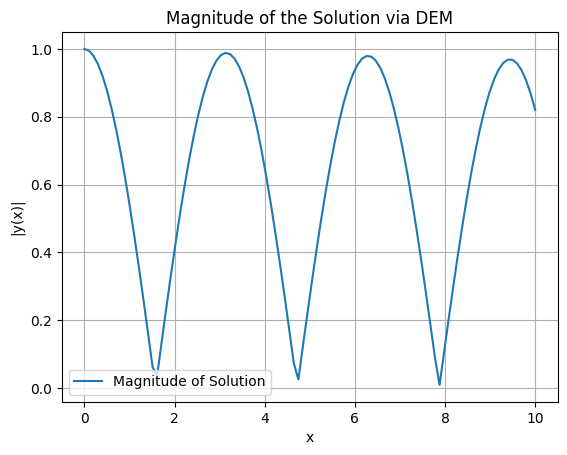

In [73]:
def visualize_solution(model_real, model_imag, x_range):
    """Visualize the full complex solution as magnitude."""
    x_min, x_max = x_range
    x_values = np.linspace(x_min, x_max, 100)
    x_tensor = torch.tensor(x_values, dtype=torch.float32).view(-1, 1)

    y_real = model_real(x_tensor).detach().numpy()
    y_imag = model_imag(x_tensor).detach().numpy()
    y_magnitude = np.sqrt(y_real**2 + y_imag**2)  # Magnitude of the complex solution

    plt.plot(x_values, y_magnitude, label="Magnitude of Solution")
    plt.xlabel("x")
    plt.ylabel("|y(x)|")
    plt.title("Magnitude of the Solution via DEM")
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_solution(model_real, model_imag, x_range)